In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, './code')

In [4]:
import ffn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm

from correlations import generate_correlation_matrix, is_pos_def
from model import generate_random_returns, generate_random_symbols, get_cholesky
from plot import plot_corr, plot_corr_cluster, plot_corr_multiple

In [5]:
plt.style.use('ggplot')
ffn.extend_pandas()

# Methodological Testing 
## Correlations (I)

The goal of this notebook is to showcase how to build returns with a specific correlation matrix. 

---

# From a correlation matrix to returns

First we load the 100-based prices in 2019 for some stock market benchmarks.

In [6]:
prices_df = pd.read_csv('prices_benchmarks.csv', index_col= 'Date', parse_dates=True)
prices_df = prices_df.asfreq('B')

We load the correlation matrix which was precomputed elsewhere, but we could use `pandas`  once we got the returns. 

In [7]:
corr_target_df = pd.read_csv("corr_benchmarks.csv", index_col="SymbolId")
corr_target_df.index.name = None

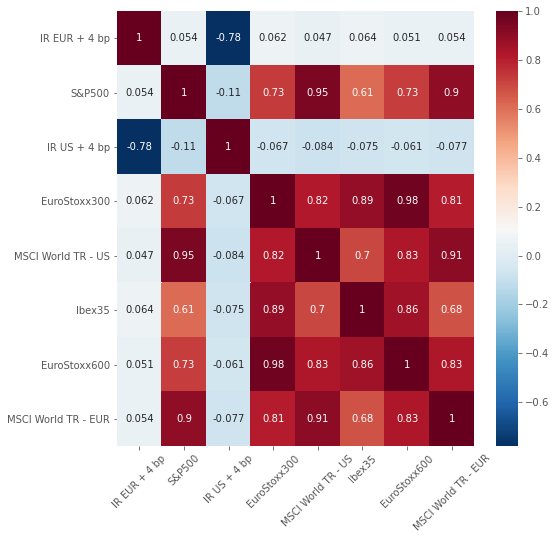

In [8]:
plot_corr(corr_target_df, my_cmap="RdBu_r")

### Generate uncorrelated returns

$$
\hat{r} \sim \mathcal{N}(\mu_r, \sigma_r)
$$

In [9]:
N_DAYS = 260
n_sids = len(prices_df.columns)

mu_returns = 0.0
sigma_returns = 1e-2

# Generate random identifiers
symbol_ids = generate_random_symbols(n_sids = n_sids)

normal_df = generate_random_returns(n_days=N_DAYS, symbol_ids=symbol_ids,
                                     mu = mu_returns, sigma=sigma_returns, 
                                    start = prices_df.index[0])

### Apply Cholesky mapping
Decompose the correlation matrix into the Cholesky factors.
$$
\Sigma = L L^{T}
$$

Then, map the normally distributed returns with L to obtain the desired correlated returns.
$$
r = L \hat{r}
$$

In [10]:
L = get_cholesky(corr_target_df)

L_projection = np.dot(L, normal_df.T).T

### Compare and check correlation matrices

In [11]:
returns_df = pd.DataFrame(data = L_projection, 
                          index = normal_df.index, columns=symbol_ids)

# Get prices
prices_synth_df = returns_df.to_price_index()

Text(0, 0.5, '100-base price')

Text(0.5, 1.0, 'Green (stock indices) - Blue (synthetic indices)')

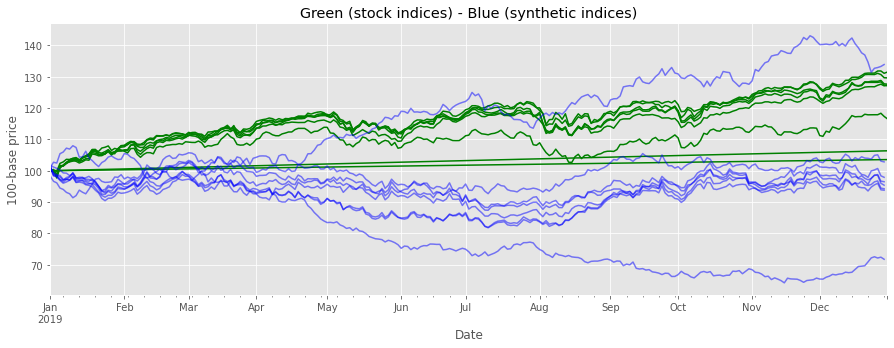

In [12]:
ax = prices_df.plot(figsize = (15,5), c = 'g', legend = False)
ax.set_ylabel('100-base price')
ax.set_title('Green (stock indices) - Blue (synthetic indices)')

prices_synth_df.plot(ax = ax, alpha = 0.5, c = 'b', legend = False)

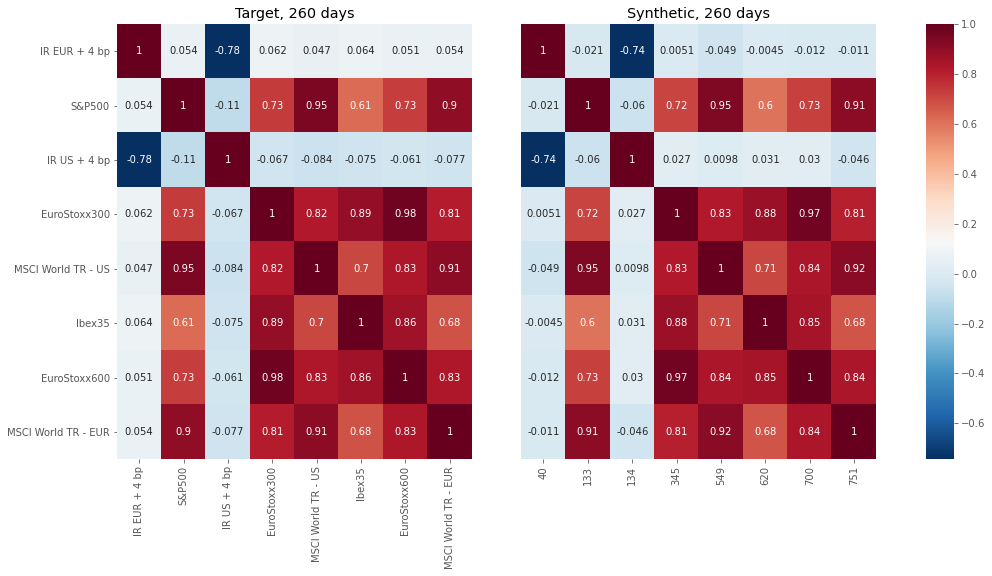

In [19]:
plot_corr_multiple(corr1=corr_target_df, corr2=returns_df.corr(), 
                   titles = ['Target, 260 days', f'Synthetic, {N_DAYS} days'],
                   my_cmap="RdBu_r")

---

# First approach to random correlations matrices

Define parameters to generate correlations.

$$
\rho \sim \mathcal{N}(0, \sigma_\rho) \quad \text{and} \quad \rho \in [\rho_\text{low}, \rho_\text{high}]
$$

In [14]:
# Magnitude bands for general entries
RHO_LOW  = 0.3
RHO_HIGH = 0.5

# Deviation from the zero mean for correlations
RHO_SIGMA = 1.5

def generate_parameters():
    # Pack in dictionary to use in correlation matrix generator
    params = dict()
    params['rho_low']   = RHO_LOW
    params['rho_high']  = RHO_HIGH
    params['rho_sigma'] = RHO_SIGMA
    
    return params

params = generate_parameters()

Generate random correlation matrices and collect their eigenvalues. 

In [15]:
N_MATRICES = 1000

eigenvalues = []

for _ in tqdm(range(N_MATRICES)):

    _corr_df = generate_correlation_matrix(symbol_ids=symbol_ids, params=params)
    
    _eigenvals = np.linalg.eigvals(_corr_df)

    eigenvalues.append(_eigenvals)

100%|██████████| 1000/1000 [00:17<00:00, 57.23it/s]


Plot the eigenvalues to see if most or few of them are semipositive definite. 

In [ ]:
for eigs in eigenvalues:
    
    mask_positive = eigs > 0
    
    _rand = np.random.rand(1)
    
    plt.scatter(eigs[mask_positive], _rand * np.ones_like(eigs[mask_positive]), c = 'g');
    plt.scatter(eigs[~mask_positive], _rand * np.ones_like(eigs[~mask_positive]), c = 'r');

plt.title(f'Spectrum of {N_MATRICES} random candidate matrices')
plt.xlabel('$\\lambda$')